
# Random Acts of Pizza

1. [Introduction](#Introduction)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
3. [Text Classification](#Text Classification)
4. [Non-Text Classification](#Non-Text Classification)
5. [Building an Ensemble Classifier](#Building-an-Ensemble-Classifier)
6. [Conclusion](#Conclusion)

## Introduction

## Exploratory Data Analysis

In [2]:
%matplotlib inline

import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/Users/dan/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/dan/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
data = pd.read_json("train.json")
data['year']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%Y'), axis=1).astype(int)
data['month']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%m'), axis=1).astype(int)
data['day']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).strftime('%d'), axis=1).astype(int)
data['dayofweek']=data.apply(lambda x: datetime.utcfromtimestamp(x['unix_timestamp_of_request_utc']).weekday(), axis=1).astype(int)
data['number_of_words_in_title']=data.apply(lambda x: len(x['request_title']), axis=1).astype(int)
data['number_of_words_in_text']=data.apply(lambda x: len(x['request_text']), axis=1).astype(int)
data['post_was_edited'] = data.apply(lambda x: 1 if "edit" in x['request_text'] else 0, axis=1).astype(int)
data=data.drop(['unix_timestamp_of_request'], axis=1)
data=data.drop(['request_id'], axis=1)
data=data.drop(['unix_timestamp_of_request_utc'], axis=1)
data=data.drop(['request_text_edit_aware'], axis=1)
data=data.drop(['request_title'], axis=1)
data=data.drop(['requester_subreddits_at_request'], axis=1)
data=data.drop(['requester_username'], axis=1)
data=data.drop(['giver_username_if_known'], axis=1)
data=data.drop(['requester_user_flair'], axis=1)
#data['requester_user_flair'] = data['requester_user_flair'].replace([None],"none")
#data['requester_user_flair'] = data['requester_user_flair'].astype("category").cat.codes
data.head(3)

,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_number_of_comments_at_retrieval,request_text,requester_account_age_in_days_at_request,requester_account_age_in_days_at_retrieval,requester_days_since_first_post_on_raop_at_request,requester_days_since_first_post_on_raop_at_retrieval,requester_number_of_comments_at_request,...,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,year,month,day,dayofweek,number_of_words_in_title,number_of_words_in_text
0,0,1,0,0,Hi I am in need of food for my 4 children we a...,0.0000,792.420405,0.0,792.420405,0,...,0,1,0,1,2011,10,5,2,39,316
1,2,5,0,0,I spent the last money I had on gas today. Im ...,501.1111,1122.279838,0.0,621.127072,0,...,34,4258,116,11168,2012,3,25,6,57,74
2,0,3,0,0,My girlfriend decided it would be a good idea ...,0.0000,771.616181,0.0,771.616181,0,...,0,3,0,3,2011,10,26,2,66,277


In [4]:
from sklearn.cross_validation import train_test_split

train_data, dev_data = train_test_split(data, test_size=0.3)
train_labels = train_data["requester_received_pizza"]
dev_labels = dev_data["requester_received_pizza"]
train_data=train_data.drop(['requester_received_pizza'], axis=1)
dev_data=dev_data.drop(['requester_received_pizza'], axis=1)

train_data_text = train_data["request_text"]
train_data=train_data.drop(['request_text'], axis=1)
dev_data_text = dev_data["request_text"]
dev_data=dev_data.drop(['request_text'], axis=1)

print (train_data.shape)
print (train_data_text.shape)
print (dev_data.shape)
print (dev_data_text.shape)

(2828, 27)
(2828,)
(1212, 27)
(1212,)


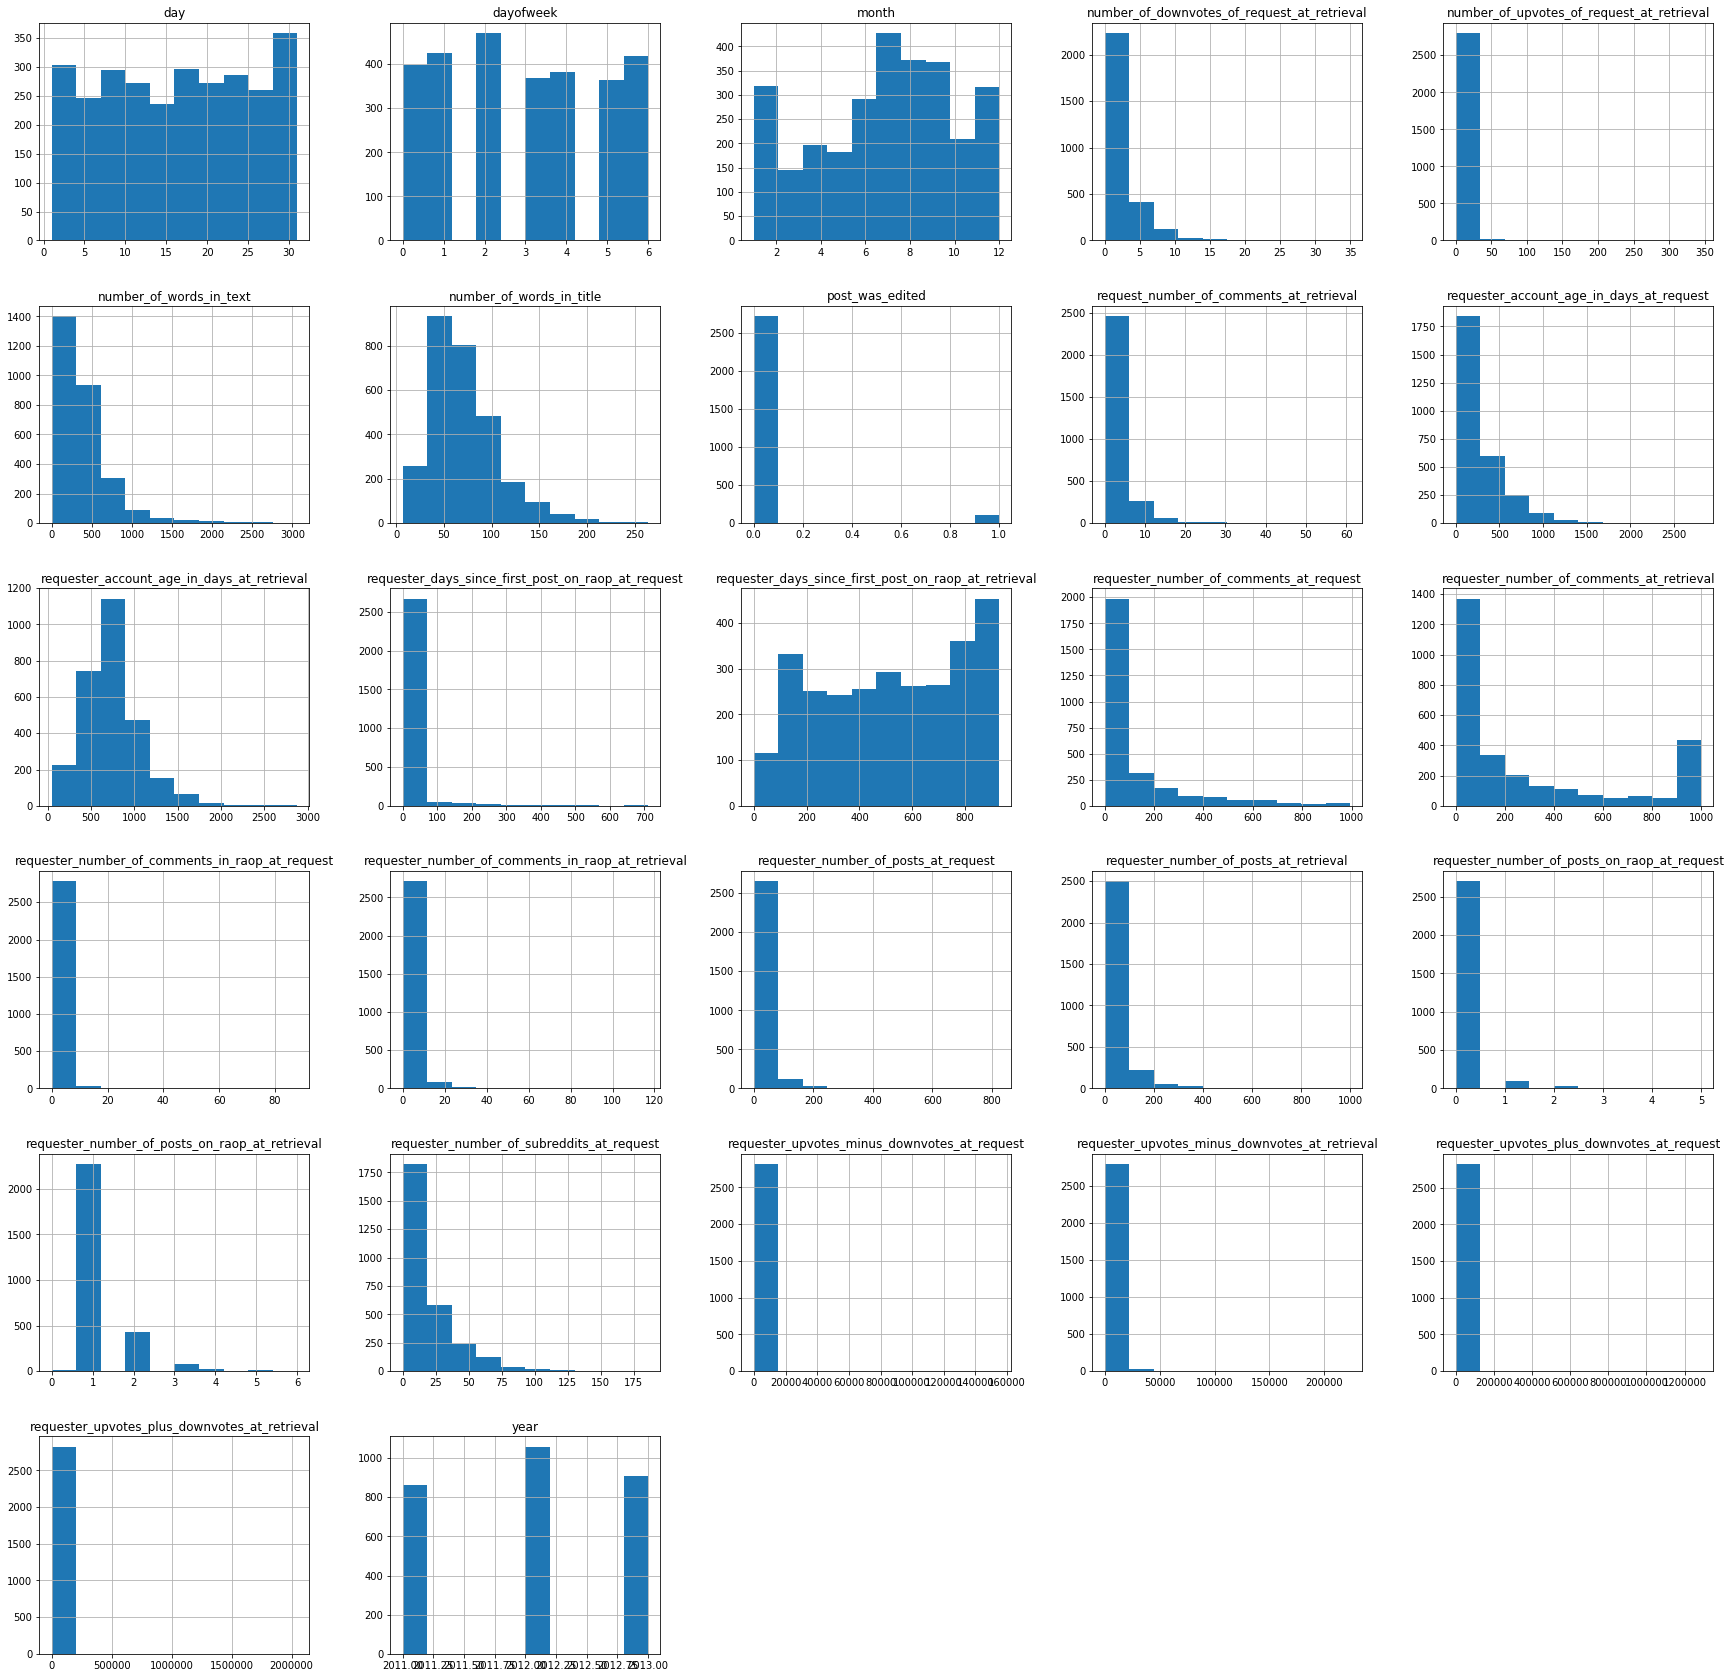

In [7]:
train_data.hist(figsize=(30,30))
plt.show()

In [5]:
# Add train_data and labels to new dataframe to determine correlation matrix
data_for_corr = train_data.copy()
data_for_corr['requester_received_pizza'] = train_labels

corr_matrix = data_for_corr.corr()
corr_matrix['requester_received_pizza'].sort_values(ascending=False)

requester_received_pizza                                1.000000
requester_number_of_posts_on_raop_at_retrieval          0.460863
request_number_of_comments_at_retrieval                 0.292187
requester_number_of_comments_in_raop_at_retrieval       0.269560
requester_account_age_in_days_at_retrieval              0.137309
requester_number_of_comments_in_raop_at_request         0.135998
requester_number_of_posts_on_raop_at_request            0.133597
requester_days_since_first_post_on_raop_at_retrieval    0.128154
requester_number_of_comments_at_retrieval               0.116286
number_of_words_in_text                                 0.115696
requester_days_since_first_post_on_raop_at_request      0.114520
number_of_upvotes_of_request_at_retrieval               0.096504
requester_upvotes_minus_downvotes_at_retrieval          0.085659
requester_account_age_in_days_at_request                0.065370
post_was_edited                                         0.057953
requester_number_of_posts

## Text Classification

## Non-Text Classification

In [6]:
lr = LogisticRegression().fit(train_data,train_labels)
y_pred = lr.predict(dev_data)
print "Accuracy = %1.3f" % lr.score(dev_data,dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.826
             precision    recall  f1-score   support

      False       0.84      0.95      0.89       915
       True       0.75      0.44      0.55       297

avg / total       0.82      0.83      0.81      1212



In [7]:
columns = [ 'requester_number_of_posts_on_raop_at_retrieval',
            'request_number_of_comments_at_retrieval']

lr2 = LogisticRegression().fit(train_data[columns],train_labels)
y_pred = lr2.predict(dev_data[columns])
print "Accuracy = %1.3f" % lr2.score(dev_data[columns],dev_labels)
print classification_report(dev_labels, y_pred)

Accuracy = 0.833
             precision    recall  f1-score   support

      False       0.85      0.95      0.89       915
       True       0.74      0.48      0.59       297

avg / total       0.82      0.83      0.82      1212



## Building an Ensemble Classifier

## Conclusion